Combine 2 models, CNN with VGGNET

Found 723 images belonging to 86 classes.
Found 235 images belonging to 86 classes.
Epoch 1/50


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0093 - loss: 4.7662 - val_accuracy: 0.0596 - val_loss: 4.3196
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.0373 - loss: 4.3506 - val_accuracy: 0.2085 - val_loss: 4.1612
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0791 - loss: 4.1696 - val_accuracy: 0.2596 - val_loss: 3.8929
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.1117 - loss: 3.9623 - val_accuracy: 0.3617 - val_loss: 3.6449
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1741 - loss: 3.6784 - val_accuracy: 0.5064 - val_loss: 3.2429
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2724 - loss: 3.3933 - val_accuracy: 0.4426 - val_loss: 3.0875
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3096 - loss: 3.0993 - val_accuracy: 0.5660 - val_loss: 2.6905
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3785 - loss: 2.7373 - val_accuracy: 0.5872 - val_loss: 2.4385
Epo

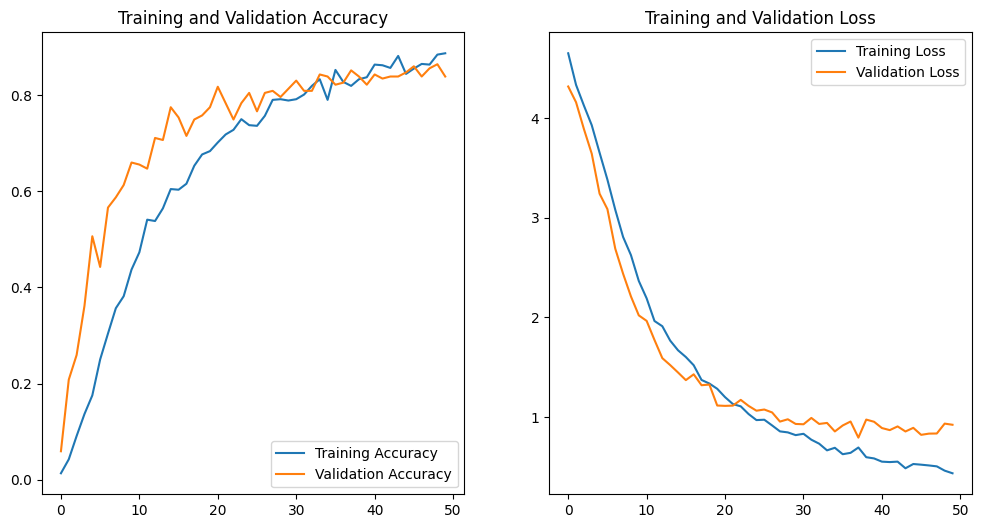

In [5]:
import os
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the directory containing the images
data_dir = r'Z:\code\python-facog\converted_images'  # Single directory for both training and validation

# Define the image size and batch size
image_size = (150, 150)  # Adjust as needed for custom CNN
batch_size = 32  # Adjust as needed

# Create ImageDataGenerator with augmentation for training
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=258/958  # 258 images for validation, 700 for training
)

# Data generator for training set with augmentation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Training data
    shuffle=True
)

# Data generator for validation set (without augmentation)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Validation data
    shuffle=True
)

# Define the CNN model using the Functional API
input_shape = (150, 150, 3)
cnn_input = Input(shape=input_shape)

# Custom CNN architecture
cnn_output = Conv2D(32, (3, 3), activation='relu')(cnn_input)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Conv2D(64, (3, 3), activation='relu')(cnn_output)
cnn_output = MaxPooling2D(pool_size=(2, 2))(cnn_output)
cnn_output = Flatten()(cnn_output)
cnn_output = Dense(128, activation='relu')(cnn_output)

# Define the VGG16 model, without the top layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_model.trainable = False  # Freeze the VGG16 layers
vgg_output = vgg_model(cnn_input)
vgg_output = GlobalAveragePooling2D()(vgg_output)

# Concatenate the outputs of both models
merged = concatenate([cnn_output, vgg_output])

# Add final dense layers for classification
merged_output = Dense(512, activation='relu')(merged)
merged_output = Dropout(0.5)(merged_output)
merged_output = Dense(train_generator.num_classes, activation='softmax')(merged_output)

# Create the final model
combined_model = Model(inputs=cnn_input, outputs=merged_output)

# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs
epochs = 50

# Train the model and store the history
history = combined_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

# Function to plot the training history
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Save the model if needed
combined_model.save('cnn_vgg_combined_model.keras')

# Plot the history
plot_history(history)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import glob

# Load the model
model = load_model('cnn_vgg_combined_model.keras')

# Function to predict and display an image
def predict_and_display_image(img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(150, 150))  # Adjust size if needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale as done during training

    # Make prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)[0]

    # Display the image with prediction
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')  # Adjust to show class name if needed
    plt.axis('off')  # Turn off axis
    plt.show()

# Path to the images
test_image_path_pattern = r'Z:\code\python-facog\sample_data\*.jpg'

# Retrieve all image paths that match the pattern
test_image_paths = glob.glob(test_image_path_pattern)

# Loop through each image and display the prediction
for test_image_path in test_image_paths:
    predict_and_display_image(test_image_path)
